# Autofocus


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import aps.ai.autoalignment.beamline28IDB.optimization.configs as configs
import aps.ai.autoalignment.beamline28IDB.optimization.movers as movers
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
from aps.ai.autoalignment.beamline28IDB.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline28IDB.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline28IDB.simulation.facade.focusing_optics_interface import (
    Layout,
    get_default_input_features,
)
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    EmptyBeamException,
    HybridFailureException,
    PreProcessorFiles,
    load_shadow_beam,
)
from aps.ai.autoalignment.common.util.wrappers import get_distribution_info, load_beam, plot_distribution
from datetime import datetime
import joblib

%matplotlib inline

28-ID - VKB Pitch Motor Resolution: 2e-05 deg
Qt5Agg: unable to import specified backend (or its dependency); no plots


**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.
Traceback (most recent call last):
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot.py", line 57, in uti_plot_init
    _backend = uti_plot_matplotlib.Backend(backend, fname_format)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot_matplotlib.py", line 27, in __init__
    backend = self._init_ipython(backend)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot_matplotlib.py", line 724, in _init_ipython
    get_ipython().magic('matplotlib ' + b)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.

In [3]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)

In [91]:
-np.log(8)

-2.0794415416798357

In [92]:
class OptimizationParameters:
    def __init__(self):
        self.move_motors_ranges = configs.DEFAULT_MOVEMENT_RANGES

        self.params = {
            "sum_intensity_soft_constraint": 7e3,
            "sum_intensity_hard_constraint": 6.5e3,
            "reference_parameters_h_v": {"peak_distance": (0.0, 0.0)},
            #            "centroid_sigma_loss_threshold_dependency": CentroidSigmaLossThresholdDependency.FULLY_DYNAMIC,
            #            "centroid_sigma_loss_hard_thresholds": [0.01, 0.03],
            "loss_parameters": ["negative_log_peak_intensity", "peak_distance"],#["peak", "fwhm", "weighted_sum_intensity"],
            "multi_objective_optimization": True,
            "n_pitch_trans_motor_trials": 50,
            "n_all_motor_trials": 100,
            "moo_thresholds": {"peak_distance":0.02, "negative_log_peak_intensity":-np.log(8)},
        }

In [93]:
class SimulationParameters:
    def __init__(self):
        detector_x = 2160 * 0.65 * 1e-3
        detector_y = 2560 * 0.65 * 1e-3

        xrange = [-detector_x / 2, detector_x / 2]
        yrange = [-detector_y / 2, detector_y / 2]

        self.params = {
            "xrange": xrange,
            "yrange": yrange,
            "nbins_h": 2048,
            "nbins_v": 2048,
            "do_gaussian_fit": False,
            "implementor": Implementors.SHADOW,
            "random_seed": DEFAULT_RANDOM_SEED,
        }

In [94]:

def setup_work_dir():
    root_dir = Path(aps.__path__[0]).parents[0]
    work_dir = root_dir / "work_directory/28-ID"
    os.chdir(work_dir)

In [95]:
def print_beam_attributes(loss_parameters, hist, dw, title):
    loss_dw_functions = {
        "peak": opt_common._get_peak_distance_from_dw,
        "centroid": opt_common._get_centroid_distance_from_dw,
        "sigma": opt_common._get_sigma_from_dw,
        "fwhm": opt_common._get_fwhm_from_dw,
    }
    loss_hist_functions = {
        "weighted_sum_intensity": lambda hist: opt_common._get_weighted_sum_intensity_from_hist(hist, 2)
    }

    attribs = {}
    for ltype, lfn in loss_dw_functions.items():
        if ltype in loss_parameters:
            loss = lfn(dw)
            attribs[ltype] = loss
            print(f"{title} system {ltype}: {loss:4.3e}")
    for ltype, lfn in loss_hist_functions.items():
        if ltype in loss_parameters:
            loss = lfn(hist)
            attribs[ltype] = loss
            print(f"{title} system {ltype}: {loss:4.3e}")
    return attribs

In [81]:
plot_mode = PlotMode.INTERNAL
aspect_ratio = AspectRatio.AUTO
color_map = ColorMap.VIRIDIS

In [82]:
setup_work_dir()
clean_up()

sim_params = SimulationParameters()
print("Simulation parameters")
print(sim_params.__dict__)

Simulation parameters
{'params': {'xrange': [-0.7020000000000001, 0.7020000000000001], 'yrange': [-0.8320000000000001, 0.8320000000000001], 'nbins_h': 2048, 'nbins_v': 2048, 'do_gaussian_fit': False, 'implementor': 0, 'random_seed': 29758}}


In [96]:
opt_params = OptimizationParameters()

print("Motors and movement ranges")
print(opt_params.move_motors_ranges)

print("Optimization parameters")
print(opt_params.params)

Motors and movement ranges
{'hb_1': [-25, 25], 'hb_2': [-25, 25], 'hb_pitch': [-0.002, 0.002], 'hb_trans': [-0.03, 0.03], 'vb_bender': [-20.0, 20.0], 'vb_pitch': [-0.002, 0.002], 'vb_trans': [-0.03, 0.03]}
Optimization parameters
{'sum_intensity_soft_constraint': 7000.0, 'sum_intensity_hard_constraint': 6500.0, 'reference_parameters_h_v': {'peak_distance': (0.0, 0.0)}, 'loss_parameters': ['negative_log_peak_intensity', 'peak_distance'], 'multi_objective_optimization': True, 'n_pitch_trans_motor_trials': 50, 'n_all_motor_trials': 100, 'moo_thresholds': {'peak_distance': 0.02, 'negative_log_peak_intensity': -2.0794415416798357}}


In [97]:
input_beam_path = "primary_optics_system_beam.dat"

clean_up()

# Initializing the focused beam from simulation
input_features = get_default_input_features(layout=Layout.AUTO_FOCUSING)
input_beam = load_shadow_beam(input_beam_path)
focusing_system = focusing_optics_factory_method(
    execution_mode=ExecutionMode.SIMULATION,
    implementor=Implementors.SHADOW,
    bender=True,
)

focusing_system.initialize(
    input_photon_beam=input_beam,
    rewrite_preprocessor_files=PreProcessorFiles.NO,
    layout=Layout.AUTO_FOCUSING,
    input_features=input_features,
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


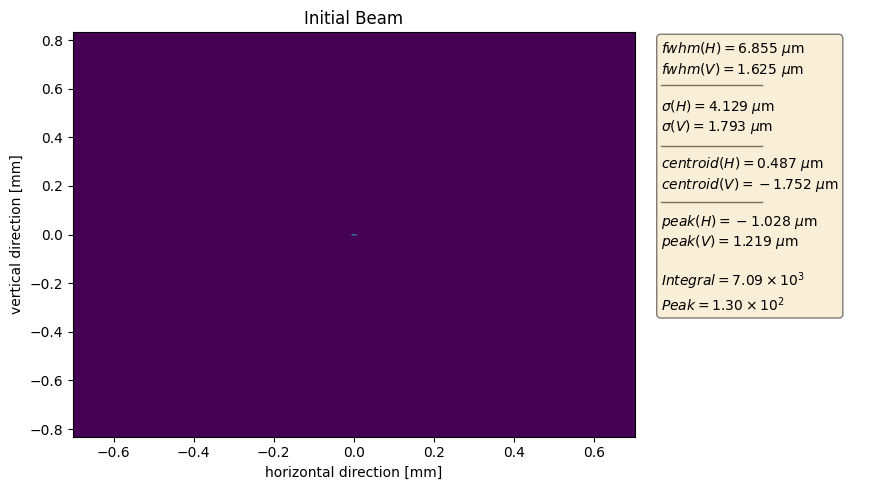

In [57]:
beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system=focusing_system, photon_beam=None, **sim_params.params)
plot_distribution(
    beam=beam,
    title="Initial Beam",
    plot_mode=plot_mode,
    aspect_ratio=aspect_ratio,
    color_map=color_map,
    **sim_params.params,
)

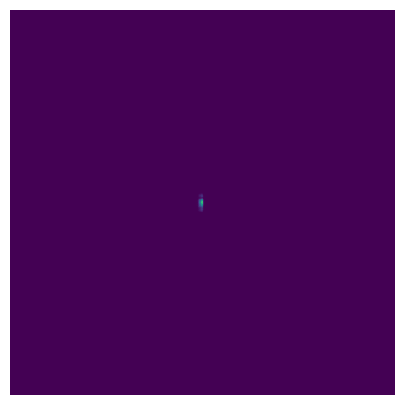

In [58]:
plt.figure(figsize=[5, 5])
plt.imshow(hist.data_2D[700:-700,700:-700])
plt.axis("off")
plt.show()

In [59]:
attribs_focus = print_beam_attributes(["peak", "fwhm", "weighted_sum_intensity"], hist, dw, "Focused beam")

Focused beam system peak: 1.106e-03
Focused beam system fwhm: 7.045e-03
Focused beam system weighted_sum_intensity: 7.621e-02


In [60]:
mots = list(opt_params.move_motors_ranges.keys())
initial_absolute_positions = {k: movers.get_absolute_positions(focusing_system, k)[0] for k in mots}
print("Focused absolute position are", initial_absolute_positions)



Focused absolute position are {'hb_1': -168.0, 'hb_2': -161.0, 'hb_pitch': 0.17188733853924987, 'hb_trans': 0.0, 'vb_bender': 419.0, 'vb_pitch': 0.17188733853924987, 'vb_trans': 0.0}


In [62]:
# Adding random perturbation to the motor values
initial_movement, focusing_system, (beam_init, hist_init, dw_init) = opt_common.get_random_init(
    focusing_system,
    motor_types_and_ranges=opt_params.move_motors_ranges,
    intensity_sum_threshold=opt_params.params["sum_intensity_hard_constraint"],
    **sim_params.params,
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is (ABSOLUTE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-170.8, -142.3, 0.17038733853924987, 0.0436, 436.8, 0.17029733853924986, 0.0116]
Random initialization is (RELATIVE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-2.7551532064389157, 18.730881674178676, -0.0014888907394445168, 0.021807165970788557, 17.79082612405135, -0.0015883242885191184, 0.011637539589012494]


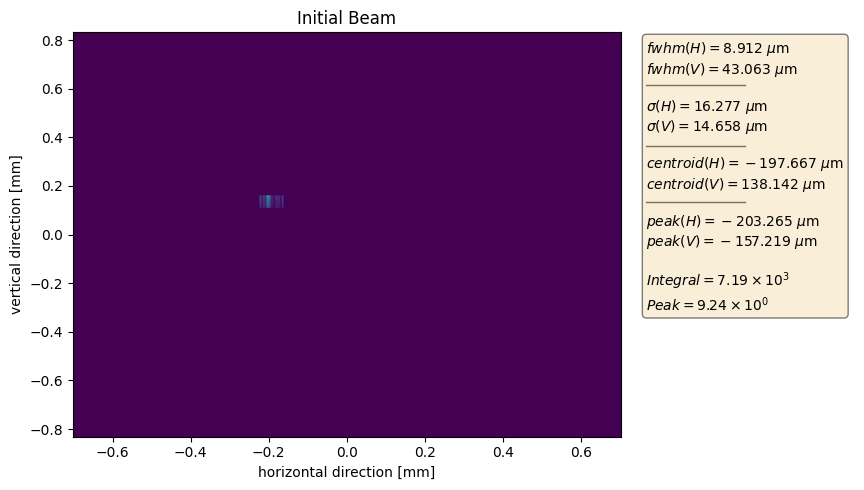

In [63]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(focusing_system=focusing_system, photon_beam=None, **sim_params.params)
plot_distribution(
    beam=beam_pert,
    title="Initial Beam",
    plot_mode=plot_mode,
    aspect_ratio=aspect_ratio,
    color_map=color_map,
    **sim_params.params,
)
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

In [64]:
perturbed_positions = initial_movement + np.array(list(initial_absolute_positions.values()))

#### WITH MOO THRESHOLDS, moving all motors together

In [98]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


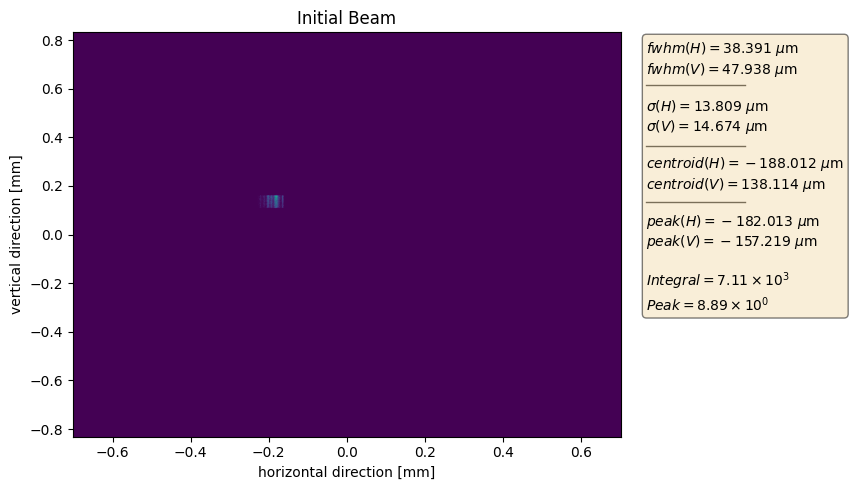

In [99]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(focusing_system=focusing_system, photon_beam=None, **sim_params.params)
plot_distribution(
    beam=beam_pert,
    title="Initial Beam",
    plot_mode=plot_mode,
    aspect_ratio=aspect_ratio,
    color_map=color_map,
    **sim_params.params,
)

In [100]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

In [101]:
# Now the optimization
opt_trial = OptunaOptimizer(
    focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    reference_parameters_h_v=opt_params.params["reference_parameters_h_v"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    **sim_params.params,
    )

In [102]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=opt_params.params["moo_thresholds"]
)

[I 2022-11-18 11:11:44,059] A new study created in memory with name: no-name-7d99d24a-f629-4eca-8bfe-c4e84235f32d


In [103]:
opt_trial.trials(150)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2022-11-18 11:11:45,065] Trial 0 finished with values: [-2.2408408970127427, 0.23578125409530123] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:11:45,381] Trial 1 finished with values: [-1.8294959364371695, 0.34535011178221] and parameters: {'hb_1': 0.0, 'hb_2': -22.0, 'hb_pitch': -0.0015, 'hb_trans': 0.017, 'vb_bender': 16.0, 'vb_pitch': 0.00034, 'vb_trans': 0.0187}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:11:45,699] Trial 2 pruned. 


Pruning trial with parameters [-16.0, 13.0, -0.00010000000000000005, -0.0225, 8.0, 0.0016000000000000003, 0.027100000000000006]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:11:46,022] Trial 3 finished with values: [-2.2969979292805935, 0.3953068177754928] and parameters: {'hb_1': 13.0, 'hb_2': -8.0, 'hb_pitch': -0.002, 'hb_trans': 3.469446951953614e-18, 'vb_bender': 6.0, 'vb_pitch': 0.0005800000000000002, 'vb_trans': -0.010599999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:11:46,340] Trial 4 finished with values: [-4.062101212155052, 0.39792584125281044] and parameters: {'hb_1': 6.0, 'hb_2': -13.0, 'hb_pitch': -0.002, 'hb_trans': -0.017499999999999998, 'vb_bender': -18.0, 'vb_pitch': 0.00026000000000000025, 'vb_trans': 0.0031000000000000055}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:11:46,664] Trial 5 finished with values: [-1.7447518660894916, 0.15057116798732245] and parameters: {'hb_1': 14.0, 'hb_2': 25.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': 0.015700000000000006, 'vb_bender': 19.0, 'vb_pitch': 0.0017400000000000002, 'vb_trans': -0.0010999999999999968}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:11:46,984] Trial 6 finished with values: [-2.1129326574982255, 0.10563658460031536] and parameters: {'hb_1': 24.0, 'hb_2': -12.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': -0.015199999999999998, 'vb_bender': 3.0, 'vb_pitch': 0.00198, 'vb_trans': -0.016999999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:11:47,308] Trial 7 finished with values: [-2.0126622284671982, 0.4019747734137513] and parameters: {'hb_1': -20.0, 'hb_2': 11.0, 'hb_pitch': -0.0009, 'hb_trans': 0.014700000000000005, 'vb_bender': -6.0, 'vb_pitch': -0.0014, 'vb_trans': -0.0202}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:11:47,627] Trial 8 finished with values: [-1.901099935470462, 0.3490999997356157] and parameters: {'hb_1': -24.0, 'hb_2': -11.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.0291, 'vb_bender': 8.0, 'vb_pitch': -0.00184, 'vb_trans': -0.011}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:11:47,946] Trial 9 finished with values: [-2.088820459998889, 0.1895705726506987] and parameters: {'hb_1': -18.0, 'hb_2': -17.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': -0.021199999999999997, 'vb_bender': 18.0, 'vb_pitch': -0.00031999999999999997, 'vb_trans': -0.028499999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:11:48,263] Trial 10 finished with values: [-3.3189971356169745, 0.27703912373480766] and parameters: {'hb_1': -14.0, 'hb_2': -16.0, 'hb_pitch': 0.0013, 'hb_trans': -0.026, 'vb_bender': -12.0, 'vb_pitch': -0.0017000000000000001, 'vb_trans': -0.004899999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:11:51,918] Trial 11 finished with values: [-1.7296669884463298, 0.0805637779460018] and parameters: {'hb_1': 18.0, 'hb_2': 4.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': -0.0045999999999999965, 'vb_bender': 11.0, 'vb_pitch': 0.0018400000000000005, 'vb_trans': -0.011099999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:11:59,504] Trial 12 finished with values: [-2.417131729471595, 0.05599157441140086] and parameters: {'hb_1': 17.0, 'hb_2': 4.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': -0.007499999999999996, 'vb_bender': -5.0, 'vb_pitch': 0.0018200000000000004, 'vb_trans': -0.008399999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:12:11,319] Trial 13 finished with values: [-2.6210256137116983, 0.057279191757991725] and parameters: {'hb_1': 7.0, 'hb_2': -2.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': -0.015599999999999998, 'vb_bender': -7.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': -0.017099999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the 

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:12:38,657] Trial 14 finished with values: [-3.155959819290567, 0.10207199966782292] and parameters: {'hb_1': 11.0, 'hb_2': 6.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': -0.013199999999999996, 'vb_bender': -7.0, 'vb_pitch': 0.00198, 'vb_trans': -0.0162}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:13:15,942] Trial 15 finished with values: [-3.030912582113237, 0.03050858987948527] and parameters: {'hb_1': 12.0, 'hb_2': 6.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': -0.013099999999999997, 'vb_bender': -6.0, 'vb_pitch': 0.00198, 'vb_trans': -0.018999999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:13:23,661] Trial 16 finished with values: [-2.317260757398165, 0.019341361716497613] and parameters: {'hb_1': 16.0, 'hb_2': 9.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': -0.014599999999999998, 'vb_bender': -5.0, 'vb_pitch': 0.0013800000000000002, 'vb_trans': -0.020499999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:13:30,550] Trial 17 finished with values: [-2.6862199154427358, 0.01103327836794192] and parameters: {'hb_1': 13.0, 'hb_2': 8.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': -0.021699999999999997, 'vb_bender': -4.0, 'vb_pitch': 0.0018200000000000004, 'vb_trans': -0.013099999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KeyboardInterrupt: 

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_45721/1961813434.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


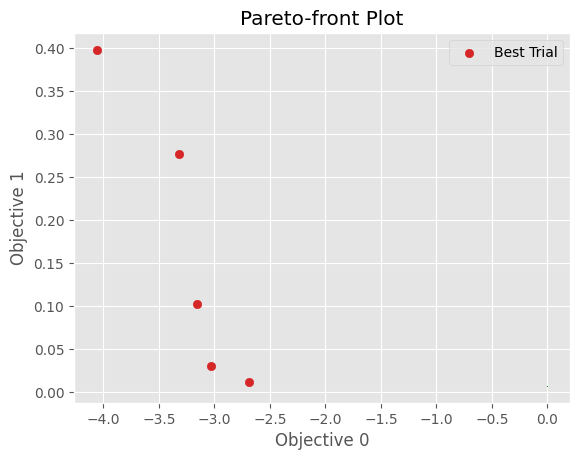

In [104]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(*attribs_focus.values(), color='green')

In [105]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['ws'])

nan 167.32037005406352
nan 848.8003514509451
nan 17.846029104620303
nan 20.74446046401871
nan 6.854360269430533


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_45721/2890865355.py:4: RuntimeWarning: invalid value encountered in log
  print(np.log(vals).sum(), t.user_attrs['ws'])


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[-4.062101212155052, 0.39792584125281044]
[-4.062101212155052, 0.39792584125281044]


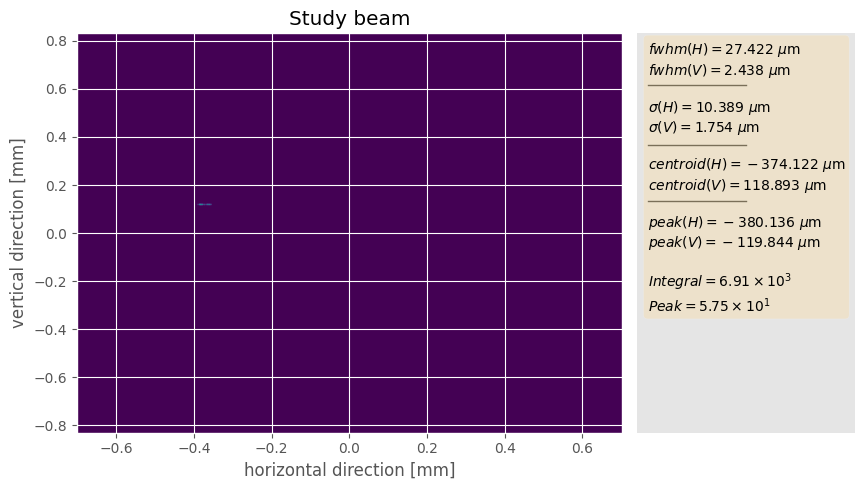

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[-3.3189971356169745, 0.27703912373480766]
[-3.3189971356169745, 0.27703912373480766]


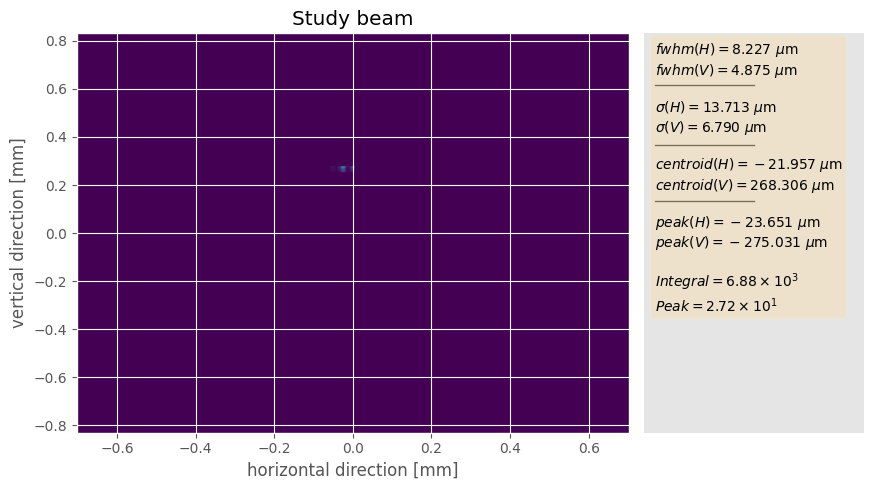

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[-3.155959819290567, 0.10207199966782292]
[-3.155959819290567, 0.10207199966782292]


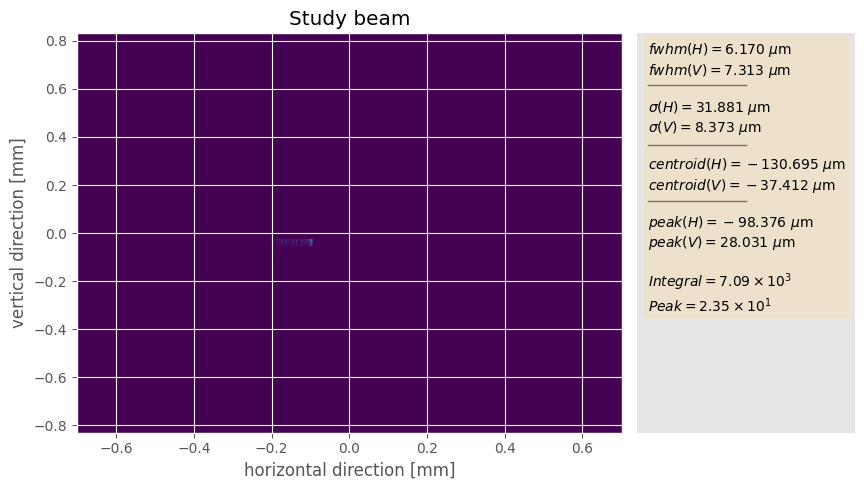

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[-3.030912582113237, 0.03050858987948527]
[-3.030912582113237, 0.03050858987948527]


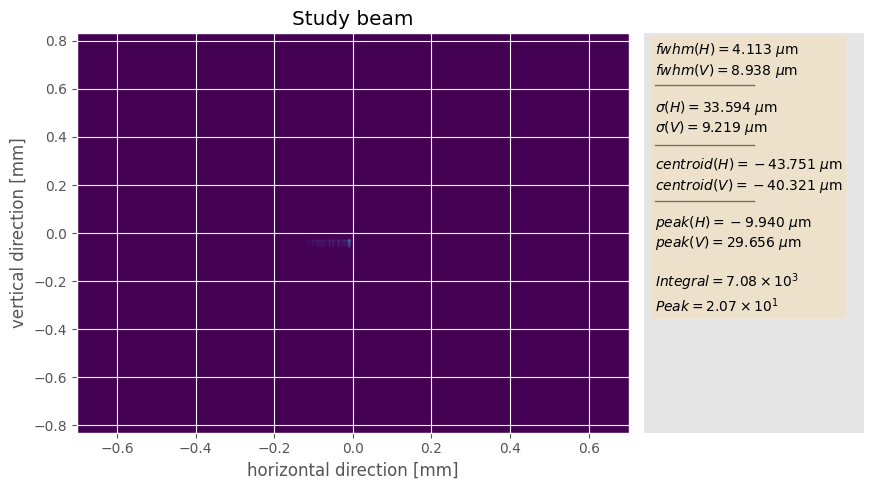

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[-2.6862199154427358, 0.01103327836794192]
[-2.6862199154427358, 0.01103327836794192]


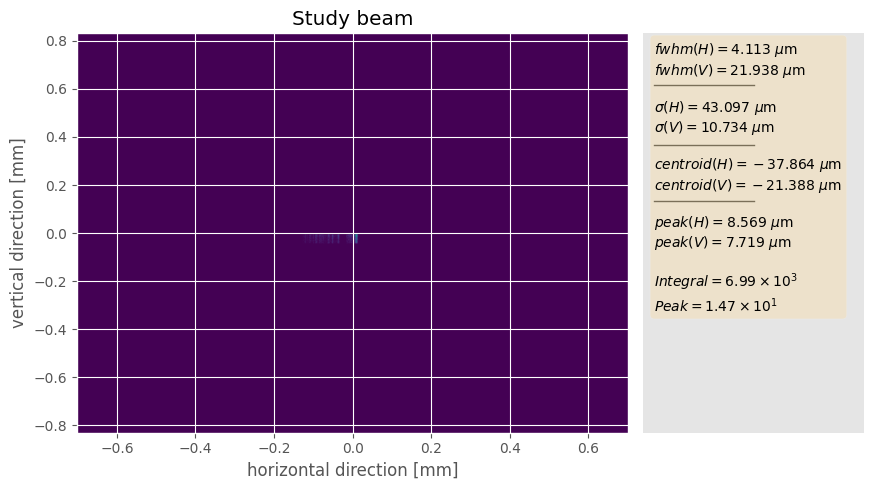

In [108]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    print(vals)
    # plt.figure(figsize=[5, 5])
    # plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    # plt.axis("off")
    # plt.show()
    plot_distribution(
        beam=opt_trial.beam_state.photon_beam,
        title="Study beam",
        plot_mode=plot_mode,
        aspect_ratio=aspect_ratio,
        color_map=color_map,
        **sim_params.params,
    )

#### WITH MOO THRESHOLDS, moving all motors together

In [109]:
opt_params = OptimizationParameters()

In [110]:
opt_params.params

{'sum_intensity_soft_constraint': 7000.0,
 'sum_intensity_hard_constraint': 6500.0,
 'reference_parameters_h_v': {'peak_distance': (0.0, 0.0)},
 'loss_parameters': ['negative_log_peak_intensity', 'peak_distance'],
 'multi_objective_optimization': True,
 'n_pitch_trans_motor_trials': 50,
 'n_all_motor_trials': 100,
 'moo_thresholds': {'peak_distance': 0.02,
  'negative_log_peak_intensity': -2.0794415416798357}}

In [115]:
opt_params.params['loss_parameters'] = ["log_weighted_sum_intensity"]
opt_params.params["multi_objective_optimization"] = False
opt_params.params["moo_thresholds"] = None
opt_params.params["reference_parameters_h_v"] = {}

In [116]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement='absolute')

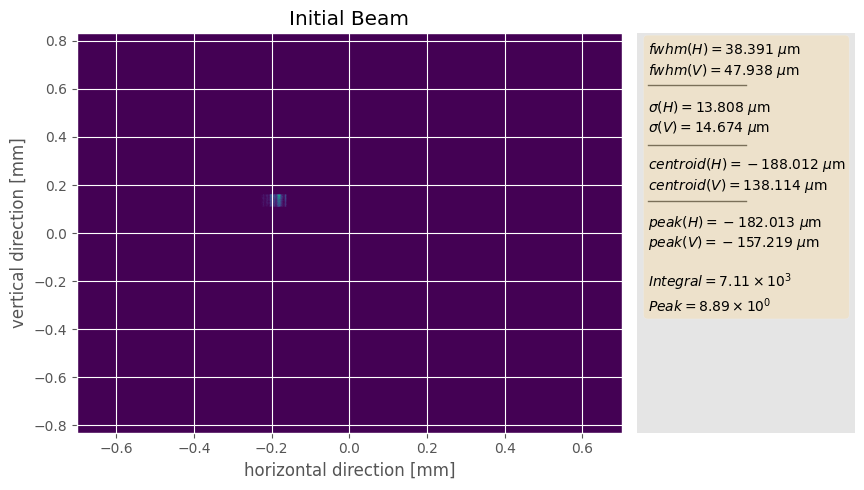

In [117]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(focusing_system=focusing_system, photon_beam=None, **sim_params.params)
plot_distribution(
    beam=beam_pert,
    title="Initial Beam",
    plot_mode=plot_mode,
    aspect_ratio=aspect_ratio,
    color_map=color_map,
    **sim_params.params,
)

In [118]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

In [119]:
# Now the optimization
opt_trial = OptunaOptimizer(
    focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    reference_parameters_h_v=opt_params.params["reference_parameters_h_v"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    **sim_params.params,
    )

In [120]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=opt_params.params["moo_thresholds"]
)

[I 2022-11-18 11:19:48,402] A new study created in memory with name: no-name-cb934521-2a4b-4181-b0cf-e29dc3ba69d3


In [ ]:
opt_trial.trials(150)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, 

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:22:05,404] Trial 36 finished with value: -2.8159133655189996 and parameters: {'hb_1': 11.0, 'hb_2': 20.0, 'hb_pitch': 0.0019, 'hb_trans': 0.009900000000000006, 'vb_bender': -16.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': -0.008399999999999998}. Best is trial 36 with value: -2.8159133655189996.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:22:07,780] Trial 37 finished with value: -2.272375114777339 and parameters: {'hb_1': 12.0, 'hb_2': 15.0, 'hb_pitch': 0.0019, 'hb_trans': 0.011800000000000005, 'vb_bender': -16.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': -0.006999999999999999}. Best is trial 36 with value: -2.8159133655189996.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:22:09,768] Trial 38 finished with value: 4.136617438921255 and parameters: {'hb_1': 7.0, 'hb_2': 2.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': -0.0033999999999999968, 'vb_bender': -7.0, 'vb_pitch': 0.001, 'vb_trans': 0.015200000000000005}. Best is trial 36 with value: -2.8159133655189996.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:22:11,732] Trial 39 finished with value: 4.87565931043222 and parameters: {'hb_1': 25.0, 'hb_2': 12.0, 'hb_pitch': 0.0, 'hb_trans': -0.0275, 'vb_bender': -9.0, 'vb_pitch': 0.00038000000000000013, 'vb_trans': -0.0013999999999999985}. Best is trial 36 with value: -2.8159133655189996.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:22:13,822] Trial 40 finished with value: 6.845213605578235 and parameters: {'hb_1': -14.0, 'hb_2': -23.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': 0.007000000000000006, 'vb_bender': 12.0, 'vb_pitch': -0.00184, 'vb_trans': -0.010199999999999997}. Best is trial 36 with value: -2.8159133655189996.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:22:15,544] Trial 41 finished with value: 3.738355885084319 and parameters: {'hb_1': 6.0, 'hb_2': 3.0, 'hb_pitch': -0.0010999999999999998, 'hb_trans': -0.0206, 'vb_bender': -17.0, 'vb_pitch': 0.0007800000000000003, 'vb_trans': -0.015599999999999998}. Best is trial 36 with value: -2.8159133655189996.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:22:17,477] Trial 42 finished with value: 6.745993177361997 and parameters: {'hb_1': -8.0, 'hb_2': -16.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.0182, 'vb_bender': -15.0, 'vb_pitch': -0.00164, 'vb_trans': -0.0009999999999999974}. Best is trial 36 with value: -2.8159133655189996.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:22:20,167] Trial 43 finished with value: -2.5288471636287535 and parameters: {'hb_1': 12.0, 'hb_2': 19.0, 'hb_pitch': 0.0019, 'hb_trans': 0.012200000000000003, 'vb_bender': -19.0, 'vb_pitch': 0.0015800000000000002, 'vb_trans': -0.009199999999999996}. Best is trial 36 with value: -2.8159133655189996.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:22:22,460] Trial 44 finished with value: 6.5523898893419 and parameters: {'hb_1': -9.0, 'hb_2': -21.0, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.029699999999999997, 'vb_bender': -9.0, 'vb_pitch': -0.0012000000000000001, 'vb_trans': 0.0172}. Best is trial 36 with value: -2.8159133655189996.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:22:24,233] Trial 45 finished with value: 6.621816941170191 and parameters: {'hb_1': -11.0, 'hb_2': 15.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.009400000000000006, 'vb_bender': -9.0, 'vb_pitch': -0.0015, 'vb_trans': -0.011099999999999999}. Best is trial 36 with value: -2.8159133655189996.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:22:26,265] Trial 46 finished with value: 5.6896920240797115 and parameters: {'hb_1': 25.0, 'hb_2': -25.0, 'hb_pitch': 0.0005, 'hb_trans': 0.025600000000000005, 'vb_bender': -17.0, 'vb_pitch': -2.0000000000000052e-05, 'vb_trans': 0.0194}. Best is trial 36 with value: -2.8159133655189996.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:22:28,050] Trial 47 finished with value: 5.906178172323881 and parameters: {'hb_1': 6.0, 'hb_2': 9.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': 0.00010000000000000286, 'vb_bender': 11.0, 'vb_pitch': -0.00056, 'vb_trans': -0.011099999999999999}. Best is trial 36 with value: -2.8159133655189996.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:22:30,035] Trial 48 finished with value: 3.0216977316293314 and parameters: {'hb_1': -7.0, 'hb_2': 23.0, 'hb_pitch': -0.0016, 'hb_trans': -0.009099999999999997, 'vb_bender': 14.0, 'vb_pitch': 0.0014200000000000003, 'vb_trans': 0.007900000000000004}. Best is trial 36 with value: -2.8159133655189996.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:22:33,092] Trial 49 finished with value: -2.9895840259384876 and parameters: {'hb_1': 11.0, 'hb_2': 21.0, 'hb_pitch': 0.0019, 'hb_trans': 0.016, 'vb_bender': -17.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': -0.0081}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:22:35,400] Trial 50 finished with value: -2.4470695277331513 and parameters: {'hb_1': 9.0, 'hb_2': 20.0, 'hb_pitch': 0.0019, 'hb_trans': 0.020000000000000004, 'vb_bender': -16.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': -0.007399999999999997}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:22:38,235] Trial 51 finished with value: 4.174221448725042 and parameters: {'hb_1': -13.0, 'hb_2': 20.0, 'hb_pitch': -0.0009, 'hb_trans': -0.011699999999999999, 'vb_bender': -10.0, 'vb_pitch': 0.00066, 'vb_trans': -0.0116}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:22:40,256] Trial 52 finished with value: 5.253304791380657 and parameters: {'hb_1': 22.0, 'hb_2': 3.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.028000000000000004, 'vb_bender': 7.0, 'vb_pitch': 0.00047999999999999996, 'vb_trans': 0.024200000000000006}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:22:42,389] Trial 53 finished with value: 2.6316289760150595 and parameters: {'hb_1': 17.0, 'hb_2': -21.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.008999999999999998, 'vb_bender': 16.0, 'vb_pitch': 0.0016200000000000003, 'vb_trans': -0.027899999999999998}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:22:44,293] Trial 54 finished with value: 2.4477034386571357 and parameters: {'hb_1': -1.0, 'hb_2': 6.0, 'hb_pitch': 0.0018, 'hb_trans': -0.0116, 'vb_bender': 16.0, 'vb_pitch': 0.0016400000000000004, 'vb_trans': 0.009900000000000006}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:22:46,504] Trial 55 finished with value: 2.797021172159913 and parameters: {'hb_1': 20.0, 'hb_2': -20.0, 'hb_pitch': -0.0013, 'hb_trans': -0.016999999999999998, 'vb_bender': -3.0, 'vb_pitch': 0.0019399999999999999, 'vb_trans': -0.0169}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:22:48,365] Trial 56 finished with value: 6.110141485892193 and parameters: {'hb_1': 7.0, 'hb_2': -10.0, 'hb_pitch': -0.0010999999999999998, 'hb_trans': -0.0182, 'vb_bender': 18.0, 'vb_pitch': -0.0007799999999999999, 'vb_trans': -0.009099999999999997}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:22:51,335] Trial 57 finished with value: 0.023189411499938153 and parameters: {'hb_1': 25.0, 'hb_2': 20.0, 'hb_pitch': 0.0019, 'hb_trans': 0.0299, 'vb_bender': -20.0, 'vb_pitch': 0.0015800000000000002, 'vb_trans': -0.0015999999999999973}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:22:53,524] Trial 58 finished with value: 4.125426064947778 and parameters: {'hb_1': 0.0, 'hb_2': -17.0, 'hb_pitch': -0.0006000000000000001, 'hb_trans': 0.019600000000000006, 'vb_bender': 1.0, 'vb_pitch': 0.0010400000000000001, 'vb_trans': 0.015000000000000006}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:22:56,073] Trial 59 finished with value: 5.697255449763547 and parameters: {'hb_1': 11.0, 'hb_2': 12.0, 'hb_pitch': -0.0012000000000000001, 'hb_trans': -0.012399999999999998, 'vb_bender': 9.0, 'vb_pitch': -0.00031999999999999997, 'vb_trans': -0.008399999999999998}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:22:57,868] Trial 60 finished with value: 6.273805725700786 and parameters: {'hb_1': 24.0, 'hb_2': 4.0, 'hb_pitch': -0.001, 'hb_trans': -0.0281, 'vb_bender': 5.0, 'vb_pitch': -0.0009, 'vb_trans': 0.0025000000000000022}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:23:00,712] Trial 61 finished with value: 6.228815411716475 and parameters: {'hb_1': -24.0, 'hb_2': -1.0, 'hb_pitch': -0.0010999999999999998, 'hb_trans': 0.010000000000000002, 'vb_bender': -4.0, 'vb_pitch': -0.00084, 'vb_trans': -0.0033999999999999968}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:23:02,970] Trial 62 finished with value: 6.888678922932269 and parameters: {'hb_1': -17.0, 'hb_2': 20.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.018400000000000007, 'vb_bender': -18.0, 'vb_pitch': -0.00164, 'vb_trans': 0.020000000000000004}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:23:05,170] Trial 63 finished with value: 6.536327998936378 and parameters: {'hb_1': -13.0, 'hb_2': -19.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': -0.0249, 'vb_bender': 0.0, 'vb_pitch': -0.00124, 'vb_trans': 0.005600000000000001}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:23:07,711] Trial 64 finished with value: 6.284170669139856 and parameters: {'hb_1': -10.0, 'hb_2': 24.0, 'hb_pitch': 0.0009000000000000002, 'hb_trans': -0.0236, 'vb_bender': -13.0, 'vb_pitch': -0.0008799999999999999, 'vb_trans': 0.0075}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:23:11,706] Trial 65 finished with value: 5.518592438665977 and parameters: {'hb_1': 5.0, 'hb_2': -11.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.0245, 'vb_bender': 17.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': -0.011299999999999998}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:23:16,042] Trial 66 finished with value: 5.452706944803589 and parameters: {'hb_1': 0.0, 'hb_2': 21.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': -0.0116, 'vb_bender': 2.0, 'vb_pitch': -0.00035999999999999986, 'vb_trans': -0.0264}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:23:18,644] Trial 67 finished with value: 6.584847498066989 and parameters: {'hb_1': -22.0, 'hb_2': 0.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.017300000000000003, 'vb_bender': 10.0, 'vb_pitch': -0.0013, 'vb_trans': -0.0032999999999999974}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:23:21,700] Trial 68 finished with value: 4.248019815180578 and parameters: {'hb_1': -4.0, 'hb_2': 15.0, 'hb_pitch': -0.00039999999999999996, 'hb_trans': -0.0192, 'vb_bender': 11.0, 'vb_pitch': 0.00102, 'vb_trans': 0.017}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:23:24,234] Trial 69 finished with value: 2.3041401074342978 and parameters: {'hb_1': 18.0, 'hb_2': -17.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.003500000000000003, 'vb_bender': -20.0, 'vb_pitch': 0.0016600000000000005, 'vb_trans': 0.0267}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:23:28,241] Trial 70 finished with value: 3.95527789180871 and parameters: {'hb_1': -11.0, 'hb_2': -4.0, 'hb_pitch': -0.0009, 'hb_trans': 0.0007000000000000027, 'vb_bender': 4.0, 'vb_pitch': 0.0007600000000000003, 'vb_trans': -0.0139}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:23:31,601] Trial 71 finished with value: 3.094509039839726 and parameters: {'hb_1': 7.0, 'hb_2': 22.0, 'hb_pitch': 0.0015, 'hb_trans': -0.0254, 'vb_bender': 17.0, 'vb_pitch': 0.0009600000000000003, 'vb_trans': -0.025599999999999998}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:23:35,289] Trial 72 finished with value: 6.735135242513106 and parameters: {'hb_1': 1.0, 'hb_2': 24.0, 'hb_pitch': 0.0005, 'hb_trans': 0.023900000000000005, 'vb_bender': -1.0, 'vb_pitch': -0.00132, 'vb_trans': 0.021200000000000004}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:23:39,490] Trial 73 finished with value: 3.108890337483618 and parameters: {'hb_1': -23.0, 'hb_2': -3.0, 'hb_pitch': -0.0009, 'hb_trans': -0.004699999999999999, 'vb_bender': -12.0, 'vb_pitch': 0.0019399999999999999, 'vb_trans': -0.0248}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:23:42,669] Trial 74 finished with value: 5.439008016012061 and parameters: {'hb_1': -23.0, 'hb_2': -20.0, 'hb_pitch': -0.0010999999999999998, 'hb_trans': -0.0224, 'vb_bender': 3.0, 'vb_pitch': -0.00023999999999999998, 'vb_trans': -0.0182}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:23:46,292] Trial 75 finished with value: 1.9250824696817668 and parameters: {'hb_1': -8.0, 'hb_2': -18.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': -0.018, 'vb_bender': 12.0, 'vb_pitch': 0.0015, 'vb_trans': -0.013499999999999998}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:23:49,138] Trial 76 finished with value: 3.168209597017865 and parameters: {'hb_1': 8.0, 'hb_2': 22.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': -0.0076999999999999985, 'vb_bender': -3.0, 'vb_pitch': 0.0013800000000000002, 'vb_trans': 0.016300000000000002}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:23:52,158] Trial 77 finished with value: 5.817734443408488 and parameters: {'hb_1': 22.0, 'hb_2': -23.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': 0.010400000000000006, 'vb_bender': -4.0, 'vb_pitch': -0.00015999999999999999, 'vb_trans': 0.017100000000000004}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:23:54,646] Trial 78 finished with value: 5.380147790595947 and parameters: {'hb_1': 2.0, 'hb_2': -7.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': -0.0133, 'vb_bender': 5.0, 'vb_pitch': 0.00010000000000000026, 'vb_trans': 0.0032000000000000015}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:23:57,396] Trial 79 finished with value: 5.702155192089834 and parameters: {'hb_1': -22.0, 'hb_2': 18.0, 'hb_pitch': -0.0010999999999999998, 'hb_trans': 0.005500000000000005, 'vb_bender': 19.0, 'vb_pitch': -0.00021999999999999993, 'vb_trans': -0.004399999999999998}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:24:00,033] Trial 80 finished with value: 2.948147208786936 and parameters: {'hb_1': -25.0, 'hb_2': -2.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': -0.010899999999999996, 'vb_bender': -2.0, 'vb_pitch': 0.0013800000000000002, 'vb_trans': 0.0109}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:24:03,204] Trial 81 finished with value: 4.95454245833495 and parameters: {'hb_1': -22.0, 'hb_2': -17.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': 0.0025000000000000022, 'vb_bender': -3.0, 'vb_pitch': 0.0006000000000000003, 'vb_trans': 0.019600000000000006}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:24:05,454] Trial 82 finished with value: 3.673645969104767 and parameters: {'hb_1': -3.0, 'hb_2': 13.0, 'hb_pitch': -0.001, 'hb_trans': -0.004799999999999999, 'vb_bender': -19.0, 'vb_pitch': 0.0009600000000000003, 'vb_trans': -0.0030999999999999986}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:24:07,993] Trial 83 finished with value: 6.961352803999592 and parameters: {'hb_1': 10.0, 'hb_2': -5.0, 'hb_pitch': 0.0, 'hb_trans': -0.011399999999999997, 'vb_bender': -7.0, 'vb_pitch': -0.00188, 'vb_trans': 0.012300000000000005}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:24:10,208] Trial 84 finished with value: 5.597526970899975 and parameters: {'hb_1': 10.0, 'hb_2': 9.0, 'hb_pitch': 0.0002000000000000001, 'hb_trans': 0.0032000000000000015, 'vb_bender': -2.0, 'vb_pitch': -0.0003399999999999998, 'vb_trans': -0.0169}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:24:12,520] Trial 85 finished with value: 4.166278654931842 and parameters: {'hb_1': 13.0, 'hb_2': 23.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': -0.023299999999999998, 'vb_bender': 20.0, 'vb_pitch': 0.0009400000000000003, 'vb_trans': 0.003500000000000003}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:24:14,432] Trial 86 finished with value: 1.7098386060168027 and parameters: {'hb_1': -21.0, 'hb_2': 5.0, 'hb_pitch': -0.0016, 'hb_trans': 0.018800000000000004, 'vb_bender': 8.0, 'vb_pitch': 0.0017200000000000002, 'vb_trans': -0.006599999999999998}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:24:16,763] Trial 87 finished with value: 1.4039390642626428 and parameters: {'hb_1': -18.0, 'hb_2': 2.0, 'hb_pitch': -0.0005, 'hb_trans': -0.022799999999999997, 'vb_bender': 3.0, 'vb_pitch': 0.0019399999999999999, 'vb_trans': 0.006100000000000001}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:24:20,742] Trial 88 finished with value: -2.830089256451903 and parameters: {'hb_1': 7.0, 'hb_2': 17.0, 'hb_pitch': 0.0019, 'hb_trans': 0.014900000000000004, 'vb_bender': -19.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': -0.008799999999999999}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:24:23,252] Trial 89 finished with value: 5.411710327030393 and parameters: {'hb_1': 13.0, 'hb_2': -5.0, 'hb_pitch': 0.0002000000000000001, 'hb_trans': -0.0215, 'vb_bender': 14.0, 'vb_pitch': 0.00010000000000000026, 'vb_trans': 0.004400000000000001}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:24:25,539] Trial 90 finished with value: 6.884189676497859 and parameters: {'hb_1': -14.0, 'hb_2': 4.0, 'hb_pitch': -0.0013, 'hb_trans': -0.0298, 'vb_bender': 14.0, 'vb_pitch': -0.00188, 'vb_trans': -0.0011999999999999962}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:24:28,807] Trial 91 finished with value: 5.416432409011911 and parameters: {'hb_1': 18.0, 'hb_2': 13.0, 'hb_pitch': -0.002, 'hb_trans': 0.011200000000000002, 'vb_bender': 7.0, 'vb_pitch': -0.0002599999999999998, 'vb_trans': -0.023899999999999998}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:24:31,309] Trial 92 pruned. 


Pruning trial with parameters [16.0, 25.0, 0.0013, -0.0248, -9.0, 0.0014800000000000004, 0.026100000000000005]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:24:33,361] Trial 93 finished with value: 6.271204177056384 and parameters: {'hb_1': -7.0, 'hb_2': -25.0, 'hb_pitch': -0.001, 'hb_trans': 0.016200000000000006, 'vb_bender': -1.0, 'vb_pitch': -0.00058, 'vb_trans': 0.028000000000000004}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:24:35,651] Trial 94 finished with value: 2.649960605019577 and parameters: {'hb_1': 5.0, 'hb_2': -3.0, 'hb_pitch': 0.0005, 'hb_trans': 0.0040000000000000036, 'vb_bender': -1.0, 'vb_pitch': 0.0013200000000000004, 'vb_trans': -0.000899999999999998}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:24:37,862] Trial 95 finished with value: 5.603382441707158 and parameters: {'hb_1': 17.0, 'hb_2': 23.0, 'hb_pitch': -0.0013, 'hb_trans': -0.0223, 'vb_bender': -17.0, 'vb_pitch': -0.0005, 'vb_trans': -0.026}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:24:40,403] Trial 96 finished with value: 3.7674318859438576 and parameters: {'hb_1': 3.0, 'hb_2': 9.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': -0.003999999999999997, 'vb_bender': -10.0, 'vb_pitch': 0.001, 'vb_trans': 0.0022000000000000006}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:24:42,924] Trial 97 finished with value: 5.516563925399347 and parameters: {'hb_1': 8.0, 'hb_2': -9.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': 0.025100000000000004, 'vb_bender': -15.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': 0.0068000000000000005}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:24:45,387] Trial 98 finished with value: 7.022943864244565 and parameters: {'hb_1': 3.0, 'hb_2': -2.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': -0.007099999999999999, 'vb_bender': -6.0, 'vb_pitch': -0.00188, 'vb_trans': 0.0262}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:24:47,994] Trial 99 finished with value: 6.837267336050247 and parameters: {'hb_1': -1.0, 'hb_2': -25.0, 'hb_pitch': -0.0013, 'hb_trans': 0.026400000000000007, 'vb_bender': 10.0, 'vb_pitch': -0.0014399999999999999, 'vb_trans': 0.023200000000000005}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:24:51,157] Trial 100 finished with value: 3.5593766787104038 and parameters: {'hb_1': 17.0, 'hb_2': 3.0, 'hb_pitch': -0.00039999999999999996, 'hb_trans': 0.003500000000000003, 'vb_bender': -4.0, 'vb_pitch': 0.00068, 'vb_trans': -0.0298}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:24:54,160] Trial 101 finished with value: 6.1241918847336665 and parameters: {'hb_1': -23.0, 'hb_2': -15.0, 'hb_pitch': -0.002, 'hb_trans': 0.028500000000000004, 'vb_bender': -20.0, 'vb_pitch': -0.00074, 'vb_trans': -0.006599999999999998}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:24:57,060] Trial 102 finished with value: 5.603152977806012 and parameters: {'hb_1': 20.0, 'hb_2': 23.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.013000000000000005, 'vb_bender': 7.0, 'vb_pitch': -0.00015999999999999999, 'vb_trans': -0.004899999999999998}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:25:00,510] Trial 103 finished with value: 6.933750360334495 and parameters: {'hb_1': -2.0, 'hb_2': -14.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': -0.0209, 'vb_bender': -9.0, 'vb_pitch': -0.00186, 'vb_trans': 0.012000000000000004}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:25:05,222] Trial 104 finished with value: -2.3675745631729064 and parameters: {'hb_1': 7.0, 'hb_2': 13.0, 'hb_pitch': 0.0019, 'hb_trans': 0.014200000000000004, 'vb_bender': -20.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': -0.009399999999999999}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:25:10,178] Trial 105 finished with value: 6.3320588567106535 and parameters: {'hb_1': -6.0, 'hb_2': 6.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.016, 'vb_bender': 14.0, 'vb_pitch': -0.0008799999999999999, 'vb_trans': 0.0023000000000000034}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:25:12,828] Trial 106 finished with value: 2.7654138703193656 and parameters: {'hb_1': 14.0, 'hb_2': -1.0, 'hb_pitch': -0.0010999999999999998, 'hb_trans': 0.0051, 'vb_bender': -11.0, 'vb_pitch': 0.0010800000000000002, 'vb_trans': -0.015499999999999998}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:25:16,615] Trial 107 finished with value: 5.798605400400757 and parameters: {'hb_1': -14.0, 'hb_2': -1.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': -0.001799999999999996, 'vb_bender': 18.0, 'vb_pitch': -0.0003399999999999998, 'vb_trans': -0.004799999999999999}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:25:19,436] Trial 108 finished with value: 6.45955432975622 and parameters: {'hb_1': 7.0, 'hb_2': 19.0, 'hb_pitch': -0.001, 'hb_trans': -0.029699999999999997, 'vb_bender': -1.0, 'vb_pitch': -0.00134, 'vb_trans': -0.011}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:25:22,979] Trial 109 finished with value: 3.947983781474344 and parameters: {'hb_1': 14.0, 'hb_2': 8.0, 'hb_pitch': 0.0019, 'hb_trans': -0.0045999999999999965, 'vb_bender': -10.0, 'vb_pitch': 0.0009200000000000002, 'vb_trans': 0.0017000000000000001}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:25:26,876] Trial 110 finished with value: 5.090650770257246 and parameters: {'hb_1': -19.0, 'hb_2': -25.0, 'hb_pitch': -0.002, 'hb_trans': -0.029599999999999998, 'vb_bender': 12.0, 'vb_pitch': 0.0002000000000000001, 'vb_trans': -0.006999999999999999}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:25:31,813] Trial 111 finished with value: -1.249626661893452 and parameters: {'hb_1': 0.0, 'hb_2': 16.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': 0.014000000000000005, 'vb_bender': -20.0, 'vb_pitch': 0.0016200000000000003, 'vb_trans': -0.0030999999999999986}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:25:34,969] Trial 112 finished with value: 6.308769011762535 and parameters: {'hb_1': 2.0, 'hb_2': -17.0, 'hb_pitch': -0.00039999999999999996, 'hb_trans': 0.015400000000000004, 'vb_bender': 16.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': 0.014200000000000004}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:25:38,969] Trial 113 finished with value: 6.5833061490736045 and parameters: {'hb_1': -2.0, 'hb_2': -11.0, 'hb_pitch': 0.0015, 'hb_trans': 0.025800000000000003, 'vb_bender': -18.0, 'vb_pitch': -0.0015400000000000001, 'vb_trans': -0.0206}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:25:42,733] Trial 114 finished with value: 3.2274014246446203 and parameters: {'hb_1': -14.0, 'hb_2': -19.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': -0.006799999999999997, 'vb_bender': 16.0, 'vb_pitch': 0.00196, 'vb_trans': -0.016999999999999998}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:25:45,876] Trial 115 finished with value: 6.293969599960971 and parameters: {'hb_1': 21.0, 'hb_2': -6.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.0155, 'vb_bender': 8.0, 'vb_pitch': -0.0005999999999999998, 'vb_trans': 0.026800000000000004}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:25:49,109] Trial 116 finished with value: 6.433872920929119 and parameters: {'hb_1': -1.0, 'hb_2': -13.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': 0.019500000000000003, 'vb_bender': -13.0, 'vb_pitch': -0.0008599999999999999, 'vb_trans': 0.025100000000000004}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:25:51,840] Trial 117 finished with value: 6.454011572629656 and parameters: {'hb_1': 14.0, 'hb_2': 7.0, 'hb_pitch': 0.0005, 'hb_trans': -0.023799999999999998, 'vb_bender': -17.0, 'vb_pitch': -0.00118, 'vb_trans': 0.0013000000000000025}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:25:54,609] Trial 118 finished with value: 4.398407774650121 and parameters: {'hb_1': 4.0, 'hb_2': -10.0, 'hb_pitch': -0.0018, 'hb_trans': 0.0131, 'vb_bender': -6.0, 'vb_pitch': 0.0008000000000000004, 'vb_trans': 0.007600000000000003}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:26:00,029] Trial 119 finished with value: 5.896547918966336 and parameters: {'hb_1': 9.0, 'hb_2': -17.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': 0.0020000000000000018, 'vb_bender': 19.0, 'vb_pitch': -0.00058, 'vb_trans': -0.014299999999999997}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:26:04,314] Trial 120 finished with value: 2.642378866565136 and parameters: {'hb_1': -7.0, 'hb_2': -18.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': -0.005499999999999998, 'vb_bender': 1.0, 'vb_pitch': 0.0018400000000000005, 'vb_trans': -0.0201}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:26:08,566] Trial 121 finished with value: 2.115514573320426 and parameters: {'hb_1': -11.0, 'hb_2': -6.0, 'hb_pitch': -0.0012000000000000001, 'hb_trans': 0.011100000000000006, 'vb_bender': 17.0, 'vb_pitch': 0.0019200000000000007, 'vb_trans': 0.021900000000000003}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:26:12,474] Trial 122 finished with value: 3.8567984989986144 and parameters: {'hb_1': -2.0, 'hb_2': 25.0, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.0001999999999999988, 'vb_bender': -2.0, 'vb_pitch': 0.00066, 'vb_trans': -0.0232}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:26:15,516] Trial 123 finished with value: 1.8493385152709358 and parameters: {'hb_1': -14.0, 'hb_2': 20.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': 0.0030000000000000027, 'vb_bender': 11.0, 'vb_pitch': 0.0017600000000000003, 'vb_trans': -0.002799999999999997}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:26:19,309] Trial 124 finished with value: 1.8725657964892803 and parameters: {'hb_1': -15.0, 'hb_2': 5.0, 'hb_pitch': -0.0019, 'hb_trans': -0.020499999999999997, 'vb_bender': 12.0, 'vb_pitch': 0.00136, 'vb_trans': -0.0275}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:26:22,562] Trial 125 finished with value: 5.040142502594001 and parameters: {'hb_1': -18.0, 'hb_2': -1.0, 'hb_pitch': 0.0019, 'hb_trans': -0.017599999999999998, 'vb_bender': 7.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': -0.022799999999999997}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:26:27,088] Trial 126 finished with value: 5.818409774710985 and parameters: {'hb_1': -7.0, 'hb_2': -1.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': 0.029400000000000003, 'vb_bender': 11.0, 'vb_pitch': -7.999999999999978e-05, 'vb_trans': 0.018800000000000004}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:26:31,605] Trial 127 finished with value: 6.528735976043427 and parameters: {'hb_1': -9.0, 'hb_2': 21.0, 'hb_pitch': -0.0010999999999999998, 'hb_trans': -0.0013999999999999985, 'vb_bender': 0.0, 'vb_pitch': -0.00108, 'vb_trans': 0.0155}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:26:35,962] Trial 128 finished with value: 0.8713290352145172 and parameters: {'hb_1': -13.0, 'hb_2': -20.0, 'hb_pitch': -0.0014, 'hb_trans': 0.0046, 'vb_bender': -15.0, 'vb_pitch': 0.0017000000000000001, 'vb_trans': 0.013400000000000002}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:26:43,094] Trial 129 finished with value: 1.900371083079586 and parameters: {'hb_1': 12.0, 'hb_2': -13.0, 'hb_pitch': 0.0019, 'hb_trans': 0.0165, 'vb_bender': 14.0, 'vb_pitch': 0.0019000000000000002, 'vb_trans': 0.010800000000000004}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:26:47,377] Trial 130 finished with value: 4.447466616430643 and parameters: {'hb_1': -19.0, 'hb_2': 2.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': -0.014899999999999998, 'vb_bender': 10.0, 'vb_pitch': 0.0005400000000000001, 'vb_trans': -0.0133}. Best is trial 49 with value: -2.9895840259384876.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 11:26:51,671] Trial 131 finished with value: 0.24909755288438365 and parameters: {'hb_1': -23.0, 'hb_2': 7.0, 'hb_pitch': -0.0015, 'hb_trans': -0.0006999999999999958, 'vb_bender': -17.0, 'vb_pitch': 0.0017400000000000002, 'vb_trans': 0.0131}. Best is trial 49 with value: -2.9895840259384876.


In [122]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(*attribs_focus.values(), color='green')

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_45721/1961813434.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


ValueError: `plot_pareto_front` function only supports 2 or 3 objective studies when using `targets` is `None`. Please use `targets` if your objective studies have more than 3 objectives.

In [123]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['ws'])

nan 0.10194012966677919


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_45721/2890865355.py:4: RuntimeWarning: invalid value encountered in log
  print(np.log(vals).sum(), t.user_attrs['ws'])


[-2.283369602079887]
[-2.283369602079887]


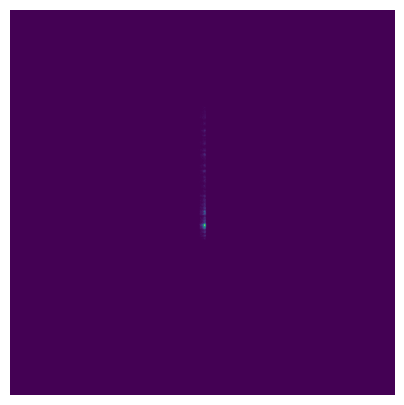

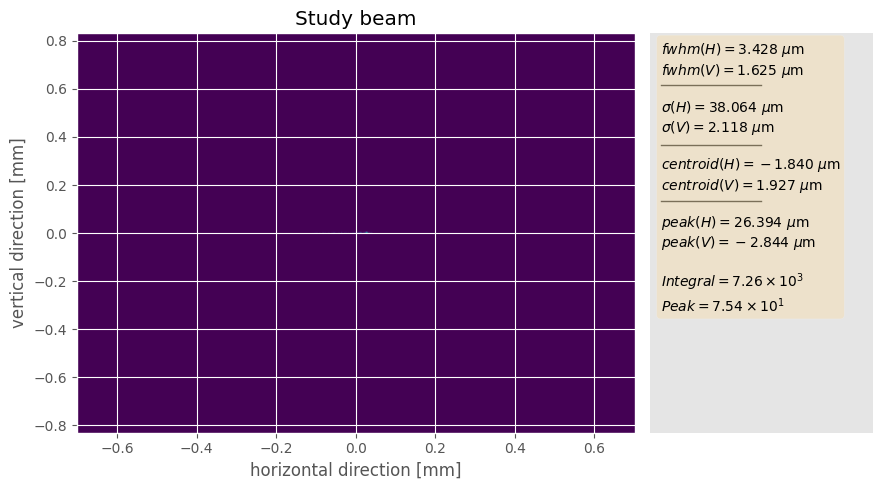

In [126]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    print(vals)
    plt.figure(figsize=[5, 5])
    plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    plt.axis("off")
    plt.show()
    plot_distribution(
        beam=opt_trial.beam_state.photon_beam,
        title="Study beam",
        plot_mode=plot_mode,
        aspect_ratio=aspect_ratio,
        color_map=color_map,
        **sim_params.params,
    )